# Poprawa kolokwium
28.06.2022 
dane: tweets_airline.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from prettytable import PrettyTable
import seaborn as sns

Import danych

In [9]:
data = pd.read_csv("tweets_airline.csv", usecols=['airline_sentiment', 'text'])

In [10]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


Przygotowanie i oczyszczenie danych

* `cleaning` - funkcja czyszczenia tekstu i usuwania emotikon, adresów https, znaków interpunkcyjnych i innych
* `stop_words` - funkcja usuwania angielskich stopwords z tweetów
* `stemming` - funkcja do stemmingu
* `text_tokenizer` - tokenizacja tekstu
* `word_count` - zliczanie słow
* `cleaning_for_visualization` - czyszczenie tekstu przed jej wizualizacją
* `visualization` - funkcja do wizualizacji podstawowych analiz dotyczących tokenów i dokumentów

In [12]:
def cleaning(text: str) -> str:
    patterns = [r'@[A-Za-z0-9-_]+',  
                r'http[s]?://\S+',
                r'#[A-Za-z0-9_]+',
                r'[0-9]+',
                r'<.*?>',
                r'[^\w\s]',
                r'_']
    text = re.sub('|'.join(patterns), '', text)
    text = " ".join(text.split()).lower()
    return text

def stop_words(stem_words: list) -> list[str]:
    stopwords_en = stopwords.words('english')
    new_list = []
    for word in stem_words:
        if word not in stopwords_en:
            new_list.append(word)
    return new_list


def stemming(text: str) -> list[str]:
    word_tokens = word_tokenize(text)
    porter = PorterStemmer()
    stem_words = []
    for w in word_tokens:
        stem_words.append(porter.stem(w))
    return stem_words


def text_tokenizer(text: str) -> list:
    text = cleaning(text)
    stem_words = stemming(text)
    wordlist = stop_words(stem_words)
    new_wordlist = [w for w in wordlist if len(w) > 3]
    return new_wordlist

def word_count(text: str) -> dict:
    word_tokens = word_tokenize(text)
    counts = dict()
    for word in word_tokens:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

def cleaning_for_visualization(text: str) -> str:
    text = cleaning(text)
    stem_words = stemming(text)
    wordlist = stop_words(stem_words)
    new_wordlist = [w for w in wordlist if len(w) > 3]
    return " ".join(new_wordlist) 

def visualization(data, title):
    plt.figure(figsize=(12,6))
    colors = ['#003f5c','#58508d', '#bc5090']
    data.plot.barh(title=title, color=np.random.choice(colors), legend=None).invert_yaxis()
    plt.xlabel("Count")
    plt.ylabel("Token")
    plt.show()
    pretty_table = PrettyTable()
    pretty_table.title = title
    pretty_table.add_column("Token", data.index)
    pretty_table.add_column("Count", data.iloc[:, 0])
    print(pretty_table)

Wizualizacja danych

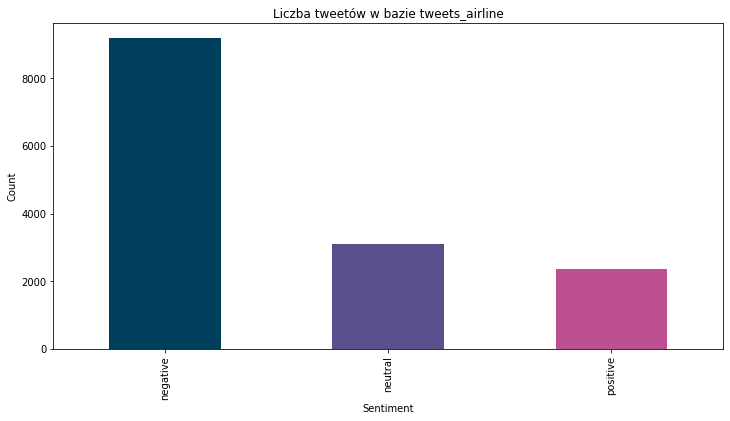

+-----------+-------+
| Sentiment | Count |
+-----------+-------+
|  negative |  9178 |
|  neutral  |  3099 |
|  positive |  2363 |
+-----------+-------+


In [15]:
plt.figure(figsize=(12,6))
plt.title("Liczba tweetów w bazie tweets_airline")
colors = ['#003f5c','#58508d', '#bc5090']
data['airline_sentiment'].value_counts().plot.bar(color=colors, legend=None)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()
pretty_table = PrettyTable()
pretty_table.add_column("Sentiment", data['airline_sentiment'].value_counts().index)
pretty_table.add_column("Count", data['airline_sentiment'].value_counts().values)
print(pretty_table)

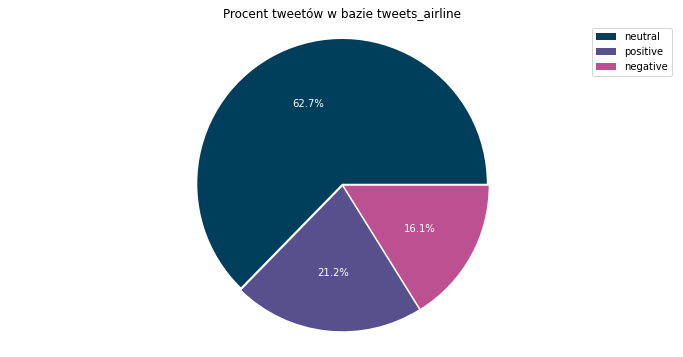

In [16]:
plt.figure(figsize=(12,6))
explode = (0.01, 0.01 , 0.01)
plt.pie(data['airline_sentiment'].value_counts(), colors=colors, labels=data['airline_sentiment'].unique(), autopct='%.1f%%', textprops={'color':"w"}, explode = explode)
plt.legend(loc='upper right')
plt.axis('equal')
plt.title("Procent tweetów w bazie tweets_airline")
plt.show()

Wordcloud

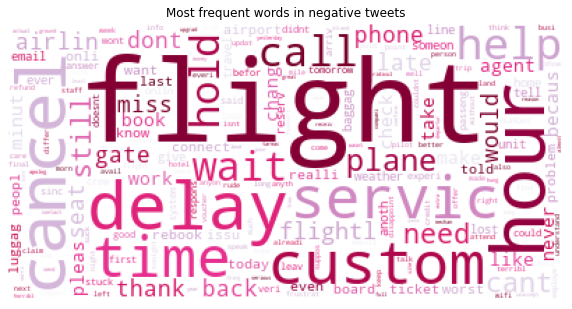

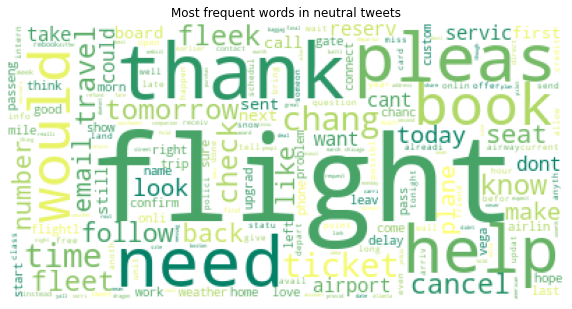

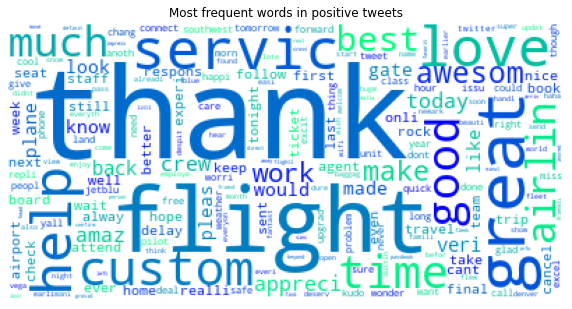

In [18]:
data_wordcloud = data.copy()
data_wordcloud['text'] = data_wordcloud['text'].apply(cleaning_for_visualization)

colormap = ['PuRd', "summer", "winter"]
sentiments = ['negative', 'neutral', 'positive']

for sentiment, theme in zip(sentiments, colormap):
    text = data_wordcloud.query('airline_sentiment == @sentiment')['text'].str.cat(sep=' ')
    plt.figure(figsize=[10, 8])
    wc = WordCloud(background_color="white", colormap=theme)
    wc.generate_from_frequencies(word_count(text))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Most frequent words in {sentiment} tweets")
    plt.show()

Wizualizacje tokenów

In [41]:
TFIDF_vec = TfidfVectorizer(tokenizer=text_tokenizer) 
zlicz_vec_all = CountVectorizer(tokenizer=text_tokenizer)

X_transform_TFIDF = TFIDF_vec.fit_transform(data['text'])
X_transform_zlicz_all = zlicz_vec_all.fit_transform(data['text'])

In [42]:
naj_tokeny = pd.DataFrame(X_transform_TFIDF.sum(axis=0), columns=TFIDF_vec.get_feature_names())

policz_tokeny = pd.DataFrame(X_transform_zlicz_all.sum(axis=0), columns=zlicz_vec_all.get_feature_names())

C:\Users\Adrian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Adrian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<Figure size 864x432 with 0 Axes>

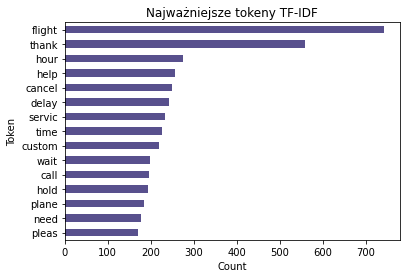

+-------------------------------+
|  Najważniejsze tokeny TF-IDF  |
+---------+---------------------+
|  Token  |        Count        |
+---------+---------------------+
|  flight |  741.7469125944787  |
|  thank  |  558.5701913937285  |
|   hour  |  274.49967260925274 |
|   help  |  256.24331937270426 |
|  cancel |  248.5407883035313  |
|  delay  |  243.4557672550858  |
|  servic |  232.68598603010713 |
|   time  |  225.95138006819658 |
|  custom |  220.15029229319265 |
|   wait  |  199.0057466756756  |
|   call  |  194.78725500927177 |
|   hold  |  194.2578603037967  |
|  plane  |  185.21163334259586 |
|   need  |  177.9546696770082  |
|  pleas  |  171.2658230033988  |
+---------+---------------------+


<Figure size 864x432 with 0 Axes>

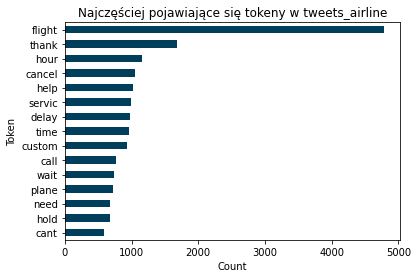

+------------------------------------------+
| Najczęściej pojawiające się tokeny w tweets_airline |
+----------------------+-------------------+
|        Token         |       Count       |
+----------------------+-------------------+
|        flight        |        4780       |
|        thank         |        1682       |
|         hour         |        1151       |
|        cancel        |        1048       |
|         help         |        1024       |
|        servic        |        990        |
|        delay         |        970        |
|         time         |        960        |
|        custom        |        933        |
|         call         |        768        |
|         wait         |        744        |
|        plane         |        720        |
|         need         |        684        |
|         hold         |        681        |
|         cant         |        580        |
+----------------------+-------------------+


In [43]:
visualization(naj_tokeny.T.sort_values(by=0, ascending=False).head(15), "Najważniejsze tokeny TF-IDF")

visualization(policz_tokeny.T.sort_values(by=0, ascending=False).head(15), "Najczęściej pojawiające się tokeny w tweets_airline")

In [44]:
data_positive = data[data['airline_sentiment'] == 'positive']
data_neutral = data[data['airline_sentiment'] == 'neutral']
data_negative = data[data['airline_sentiment'] == 'negative']

policz_vec1 = CountVectorizer(tokenizer=text_tokenizer) 
policz_vec2 = CountVectorizer(tokenizer=text_tokenizer)
policz_vec3 = CountVectorizer(tokenizer=text_tokenizer)

X_transform_positive = policz_vec1.fit_transform(data_positive['text'])
X_transform_neutral = policz_vec2.fit_transform(data_neutral['text'])
X_transform_negative = policz_vec3.fit_transform(data_negative['text'])

In [45]:
policz_tokeny_positive = pd.DataFrame(X_transform_positive.sum(axis=0), columns=policz_vec1.get_feature_names())
policz_tokeny_neutral = pd.DataFrame(X_transform_neutral.sum(axis=0), columns=policz_vec2.get_feature_names())
policz_tokeny_negative = pd.DataFrame(X_transform_negative.sum(axis=0), columns=policz_vec3.get_feature_names())

C:\Users\Adrian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Adrian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Adrian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feat

<Figure size 864x432 with 0 Axes>

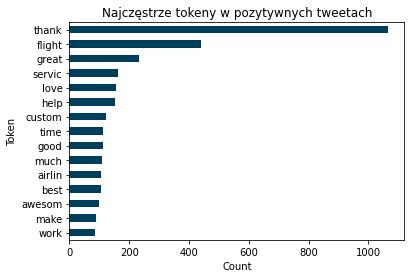

+-----------------------------------+
| Najczęstrze tokeny w pozytywnych tweetach |
+------------------+----------------+
|      Token       |     Count      |
+------------------+----------------+
|      thank       |      1067      |
|      flight      |      441       |
|      great       |      233       |
|      servic      |      161       |
|       love       |      157       |
|       help       |      153       |
|      custom      |      122       |
|       time       |      111       |
|       good       |      111       |
|       much       |      109       |
|      airlin      |      105       |
|       best       |      104       |
|      awesom      |       99       |
|       make       |       90       |
|       work       |       85       |
+------------------+----------------+


<Figure size 864x432 with 0 Axes>

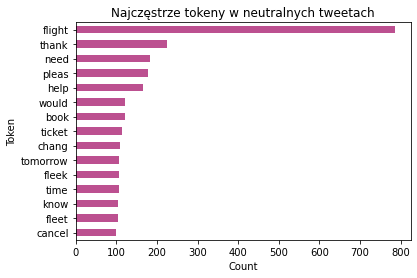

+------------------------------------+
| Najczęstrze tokeny w neutralnych tweetach |
+---------------------+--------------+
|        Token        |    Count     |
+---------------------+--------------+
|        flight       |     785      |
|        thank        |     224      |
|         need        |     184      |
|        pleas        |     178      |
|         help        |     165      |
|        would        |     122      |
|         book        |     122      |
|        ticket       |     113      |
|        chang        |     110      |
|       tomorrow      |     106      |
|        fleek        |     106      |
|         time        |     106      |
|         know        |     104      |
|        fleet        |     103      |
|        cancel       |      98      |
+---------------------+--------------+


<Figure size 864x432 with 0 Axes>

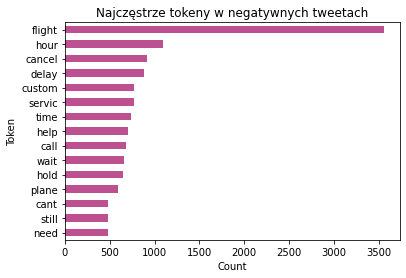

+-----------------------------------+
| Najczęstrze tokeny w negatywnych tweetach |
+------------------+----------------+
|      Token       |     Count      |
+------------------+----------------+
|      flight      |      3554      |
|       hour       |      1097      |
|      cancel      |      913       |
|      delay       |      882       |
|      custom      |      773       |
|      servic      |      767       |
|       time       |      743       |
|       help       |      706       |
|       call       |      683       |
|       wait       |      662       |
|       hold       |      648       |
|      plane       |      589       |
|       cant       |      486       |
|      still       |      482       |
|       need       |      476       |
+------------------+----------------+


In [46]:
visualization(policz_tokeny_positive.T.sort_values(by=0, ascending=False).head(15), "Najczęstrze tokeny w pozytywnych tweetach")
visualization(policz_tokeny_neutral.T.sort_values(by=0, ascending=False).head(15), "Najczęstrze tokeny w neutralnych tweetach")
visualization(policz_tokeny_negative.T.sort_values(by=0, ascending=False).head(15), "Najczęstrze tokeny w negatywnych tweetach")

Klasyfikacja tekstu

Wykorzystane modele do klasyfikacji

* Random Forest
* SVC
* MLP

Wektoryzacja i dzielenie modelu na zbiór uczący i testowy

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['airline_sentiment'], test_size=0.3, shuffle=True, stratify=data['airline_sentiment'])

In [50]:
vectorizer = CountVectorizer(tokenizer=text_tokenizer)
policz_train = vectorizer.fit_transform(X_train)
policz_test = vectorizer.transform(X_test)

In [51]:
X_train.shape

(10248,)

In [52]:
X_test.shape

(4392,)

In [54]:
def heatmap(y_test, y_pred, klasyfikator): 
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(conf_mat, annot=True, cmap="Greens", fmt='g'),
    ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive'])
    ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive'])
    plt.xlabel('Przewidywane wartości')
    plt.ylabel('Rzeczywiste wartości')
    plt.title(f'{klasyfikator}')
    plt.show()

Model Las losowy 
               precision    recall  f1-score   support

    negative       0.81      0.86      0.84      2753
     neutral       0.56      0.51      0.53       930
    positive       0.67      0.59      0.63       709

    accuracy                           0.74      4392
   macro avg       0.68      0.65      0.67      4392
weighted avg       0.74      0.74      0.74      4392



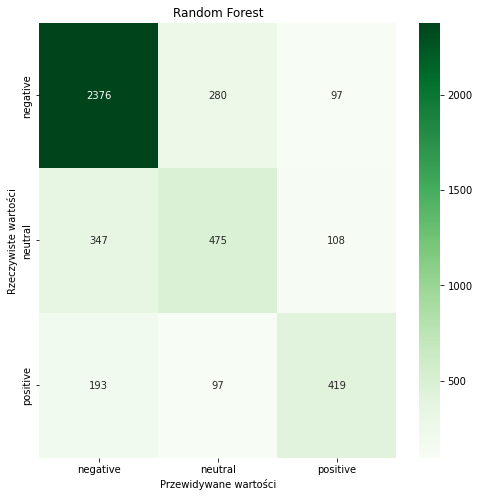

In [55]:
rfc_model = RandomForestClassifier()
rfc_model.fit(policz_train, y_train)
rfc_predict = rfc_model.predict(policz_test)

print(f'Model Las losowy \n {classification_report(y_test, rfc_predict)}')
heatmap(y_test, rfc_predict, "Random Forest")

 Model SVM 
               precision    recall  f1-score   support

    negative       0.84      0.86      0.85      2753
     neutral       0.59      0.55      0.57       930
    positive       0.69      0.66      0.67       709

    accuracy                           0.76      4392
   macro avg       0.70      0.69      0.70      4392
weighted avg       0.76      0.76      0.76      4392



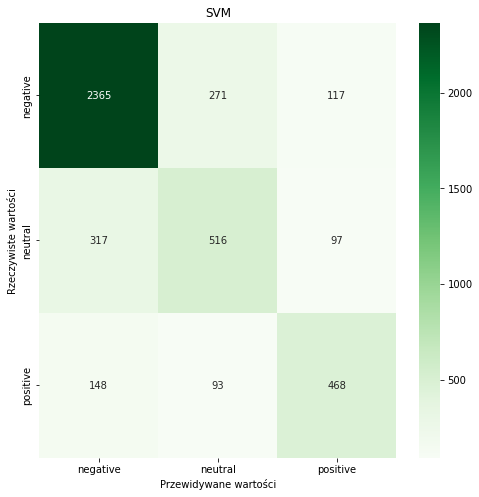

In [57]:
svm_model = LinearSVC(max_iter=3000)
svm_model.fit(policz_train, y_train)
svm_predict = svm_model.predict(policz_test)

print(f' Model SVM \n {classification_report(y_test, svm_predict)}')
heatmap(y_test, svm_predict, "SVM")

 Model Klasyfikator MLP 
               precision    recall  f1-score   support

    negative       0.83      0.90      0.86      2753
     neutral       0.65      0.53      0.58       930
    positive       0.74      0.64      0.69       709

    accuracy                           0.78      4392
   macro avg       0.74      0.69      0.71      4392
weighted avg       0.77      0.78      0.77      4392



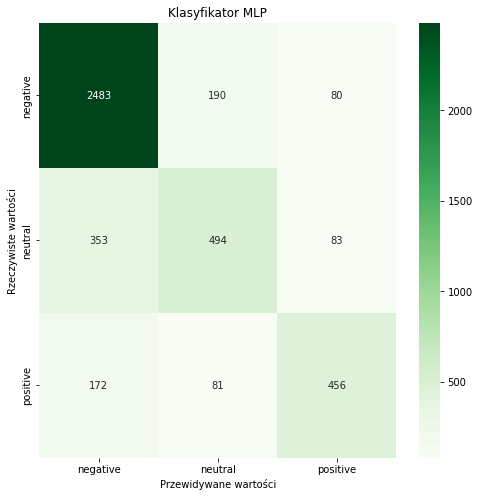

In [58]:
mlp=MLPClassifier(early_stopping=True)
mlp.fit(policz_train, y_train)
mlp_predict=mlp.predict(policz_test)
print(f' Model Klasyfikator MLP \n {classification_report(y_test, mlp_predict)}')
heatmap(y_test, mlp_predict, "Klasyfikator MLP")

**Ze wszystki klasyfikatorów największą dokładność uzyskał Klasyfikator MLP - 78%.**

**Negative class**
* Precision: Spośród wszystkich tweetów zaklasyfikowanych jako negatywne około 83% zostało przewidzianych poprawnie.
* Recall: Spośród wszystkich tweetów, które rzeczywiście są negatywne, model przewidział ten wynik poprawnie dla około 90% z nich.
* f1-score: f1 na poziomie 0.86 świadczy, że model dobrze przewiduje każdą obserwacje klasy negatywnej.

**Neutral class**
* Precision: Spośród wszystkich tweetów zaklasyfikowanych jako neutralne około 65% zostało przewidzianych poprawnie.
* Recall: Spośród wszystkich tweetów, które rzeczywiście są neutralne, model przewidział ten wynik poprawnie dla około 53% z nich.
* f1-score: f1 na poziomie 0.58 świadczy, że model średnio przewiduje każdą obserwacje klasy neutralnej.

**Positive class**
* Precision: Spośród wszystkich tweetów zaklasyfikowanych jako pozytywne około 74% zostało przewidzianych poprawnie.
* Recall: Spośród wszystkich tweetów, które rzeczywiście są pozytywne, model przewidział ten wynik poprawnie dla około 64% z nich.
* f1-score: f1 na poziomie 0.69 świadczy, że model średnio przewiduje każdą obserwacje klasy pozytywnej.


Wartości F1-score mówią o tym jak dobrze algorytm klasyfikuje poszczególne przypadki. Algorytm w dość dobrym stopniu rozpoznaje tweety negatywne 86%, natomiast rozpoznawalność tweetów neutralnych 58% jest na średnim poziomie, jest to spowodowane ilością tweetów w poszczególnych przyadkach.